In [1]:
%matplotlib inline

In [2]:
import iris
import iris.quickplot as qplt
import iris.plot as iplt
from iris.analysis import maths as iam
from iris.analysis import cartography as iac
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import pyplot as plt
import matplotlib.cm as mpl_cm
import numpy as np
import glob

In [3]:
from skimage.measure import EllipseModel
from scipy import ndimage

In [4]:
import sys
from importlib import reload
sys.path.append('/home/users/schan016/code/NOC_hostace/AnisotropicSpatialSSTVariability/src/')
from nonstationary_cov import cube_io_10x10 as cube_io_10
reload(cube_io_10)

<module 'nonstationary_cov.cube_io_10x10' from '/home/users/schan016/code/NOC_hostace/AnisotropicSpatialSSTVariability/src/nonstationary_cov/cube_io_10x10.py'>

In [5]:
plt.rcParams['figure.figsize'] = [15,10]

In [6]:
month = '04'
v = 1.5
extent = [0.0, 360.0, -90.0, 90.0]

In [7]:
ncpath = '/gws/nopw/j04/hostace/schan016/ERA_SAT_monthly/ANOMALY/'
ncpath += 'SpatialScales/matern_physical_distances_v_eq_1p5_filled_in/'
ncfiles = ncpath+'lsat_'+month+'.nc'

In [8]:
cubes = iris.load(ncfiles)

In [9]:
print(cubes)

0: land area categorical / (1)         (latitude: 36; longitude: 72)
1: infill status / (1)                 (latitude: 36; longitude: 72)
2: Lx / (km)                           (latitude: 36; longitude: 72)
3: standard_deviation / (K)            (latitude: 36; longitude: 72)
4: theta / (radians)                   (latitude: 36; longitude: 72)
5: Ly / (km)                           (latitude: 36; longitude: 72)


In [10]:
Lxs = cubes.extract('Lx')[0]
Lys = cubes.extract('Ly')[0]
thetas = cubes.extract('theta')[0]
thetas_deg = thetas.copy()
thetas_deg.convert_units('degrees')
sdevs = cubes.extract('standard_deviation')[0]
qc_code = cubes.extract('infill status')[0]
land_cat = cubes.extract('land area categorical')[0]
print(repr(Lxs))
print(repr(Lys))
print(repr(thetas_deg))
print(repr(sdevs))
print(repr(qc_code))
print(repr(land_cat))
print(Lxs)

<iris 'Cube' of Lx / (km) (latitude: 36; longitude: 72)>
<iris 'Cube' of Ly / (km) (latitude: 36; longitude: 72)>
<iris 'Cube' of theta / (degrees) (latitude: 36; longitude: 72)>
<iris 'Cube' of standard_deviation / (K) (latitude: 36; longitude: 72)>
<iris 'Cube' of infill status / (1) (latitude: 36; longitude: 72)>
<iris 'Cube' of land area categorical / (1) (latitude: 36; longitude: 72)>
Lx / (km)                              (latitude: 36; longitude: 72)
    Dimension coordinates:
        latitude                                x              -
        longitude                               -              x
    Scalar coordinates:
        fitting_model                  ps2006_kks2011_ani_r_pd
        month_number                   4
        supercategory_of_fitting_model 3_param_matern_pd
        time                           2001-04-15 23:00:00, bound=(2001-03-31 23:00:00, 2001-04-30 23:00:00)
        v_shape                        1.5
    Cell methods:
        0                 

In [11]:
qc_table = {0: 'no_fudge', 
            1: 'filled_in_with_hadcrut5_parms', 
            2: 'bavg_with_hadcrut5_parms_prior', 
            3: 'bavg_with_hadcrut5_parms_prior_due_to_fail_convergence'}
unique_qc_codes = np.unique(qc_code.data)
n_points = qc_code.data.count()
for unique_qc_code in unique_qc_codes:
    if unique_qc_code != 'MaskedConstant':
        print(unique_qc_code, 
              qc_table[unique_qc_code], 
              np.sum(qc_code.data == unique_qc_code),
              np.sum(qc_code.data == unique_qc_code)/n_points)

0 no_fudge 888 0.3425925925925926
1 filled_in_with_hadcrut5_parms 1299 0.5011574074074074
2 bavg_with_hadcrut5_parms_prior 399 0.15393518518518517
3 bavg_with_hadcrut5_parms_prior_due_to_fail_convergence 6 0.0023148148148148147


In [12]:
tr_table = {1: 'water', 
            2: 'land', 
            16: 'coast'}
unique_tr_codes = np.unique(land_cat.data)
n_points = land_cat.data.count()
for unique_tr_code in unique_tr_codes:
    if unique_tr_code != 'MaskedConstant':
        print(unique_tr_code, 
              tr_table[unique_tr_code], 
              np.sum(land_cat.data == unique_tr_code),
              np.sum(land_cat.data == unique_tr_code)/n_points)

1 water 1299 0.5011574074074074
2 land 572 0.22067901234567902
16 coast 721 0.27816358024691357


In [13]:
where_123 = np.where(np.ma.isin(qc_code.data, [2, 3]))
if len(list(where_123[0] > 0)):
    print(where_123[0])
    print(where_123[1])
    for y, x in zip(list(where_123[0]), list(where_123[1])):
        print((y, x, 
               Lxs.coord('latitude').points[y],
               Lxs.coord('longitude').points[x],
               Lxs.data[y, x], 
               Lys.data[y, x], 
               thetas.data[y, x]))

[ 0  0  0  0  0  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  5  5  5  6  7  7  7  7  7  8  8  8  8  8  9  9  9  9  9 10 10 10
 10 11 11 11 11 11 11 11 12 12 12 12 12 12 13 13 13 13 13 13 13 13 13 14
 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15 15 15 15 15 15 16 16
 16 16 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 18 18 18 18 18 18 18 18 18 19 19 19 19 19 19 19 19 19 19 19 19 19
 19 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 21 21 21 21 21
 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 22 22 22 22 22 22 22 22 22
 22 22 22 22 22 23 23 23 23 23 23 23 23 24 24 24 24 24 24 24 24 24 24 24
 25 25 25 25 25 25 25 25 25 25 25 25 26 26 26 26 26 26 26 26 26 26 26 26
 27 27 27 27 27 27 27 28 28 28 28 28 28 28 28 28 28 28 29 29 29 29 29 29
 29 29 29 29 29 29 29 29 29 29 29 29 30 30 30 30 30 30 30 30 30 30 30 30
 30 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 32

(0, 1) (-172.5, -87.5, 4970.0986328125, 1168.9361572265625, -30.814118402756556)
(0, 2) (-167.5, -87.5, 2147.987060546875, 1194.738525390625, -20.94293947650466)
(0, 7) (-142.5, -87.5, 2185.81640625, 1114.883056640625, 21.566726993023586)
(0, 8) (-137.5, -87.5, 1611.9722900390625, 1230.59228515625, 7.941312391359378)
(0, 9) (-132.5, -87.5, 2546.053955078125, 1126.3067626953125, 30.489988360599014)
(2, 0) (-177.5, -77.5, 1592.99072265625, 1389.0908203125, -14.243702108353979)
(2, 1) (-172.5, -77.5, 1617.8323974609375, 1385.222412109375, -11.612759343841965)
(2, 2) (-167.5, -77.5, 1637.18017578125, 1390.2783203125, -2.075755533582582)
(2, 3) (-162.5, -77.5, 1679.3729248046875, 1325.1400146484375, 7.653028035739711)
(2, 26) (-47.5, -77.5, 1557.5782470703125, 1305.3428955078125, 80.40215921107372)
(2, 27) (-42.5, -77.5, 1552.7393798828125, 1395.557861328125, 74.03938720672163)
(2, 28) (-37.5, -77.5, 1525.77001953125, 1352.1717529296875, 74.97715168919686)
(2, 71) (177.5, -77.5, 1547.620483

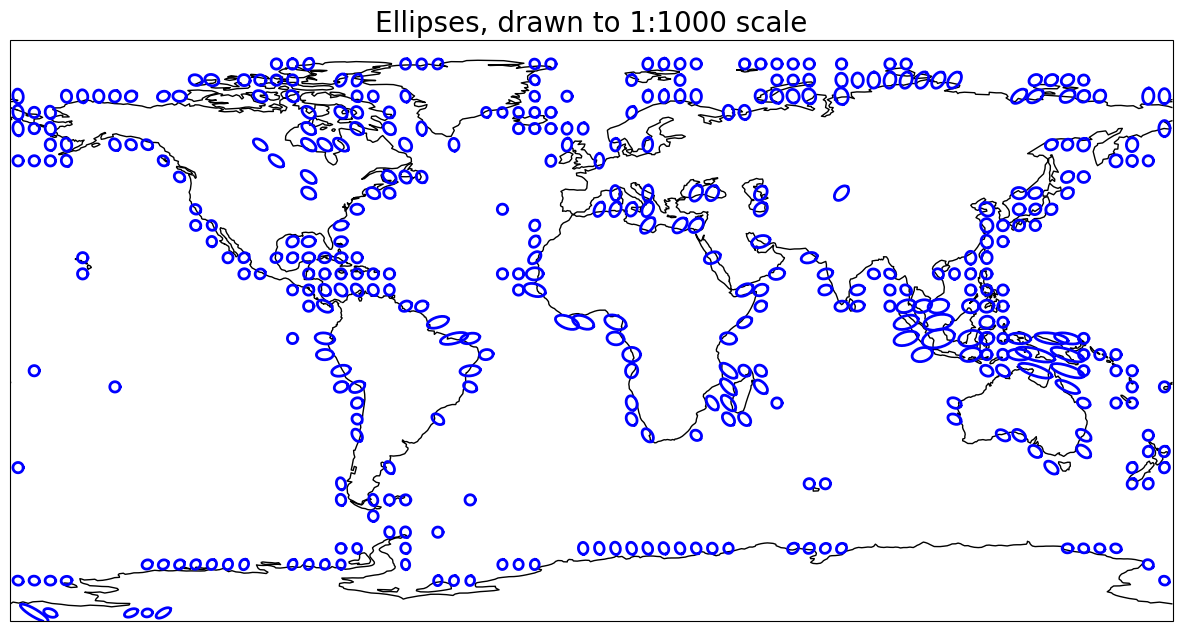

In [14]:
super_y_weird = list(where_123[0])
super_x_weird = list(where_123[1])

fig = plt.figure()
if v != 0.5:
    scaling = 1000
else:
    scaling = 3000
extent2 = extent
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
zipper = zip(super_y_weird, super_x_weird)
for n, (y_chk, x_chk) in enumerate(zipper):
    Lx_weird = Lxs[y_chk, x_chk]
    Ly_weird = Lys[y_chk, x_chk]
    theta_weird = thetas[y_chk, x_chk]
    x0 = float(Lx_weird.coord('longitude').points[0])
    y0 = float(Lx_weird.coord('latitude').points[0])
    Lx_w = float(Lx_weird.data)
    Ly_w = float(Ly_weird.data)
    angle_w = float(theta_weird.data)
    params = (x0, y0, Lx_w/scaling, Ly_w/scaling, angle_w)
    params0 = (x0, y0, Lx_w, Ly_w, angle_w*180.0/np.pi)
    print((y_chk, x_chk), params0)
    xys = EllipseModel().predict_xy(np.linspace(0, 2 * np.pi, 25), params = params)
    ax.plot(xys[:,0],  xys[:,1], linewidth = 2, color = 'blue', transform = ccrs.PlateCarree())
ax.set_title('Ellipses, drawn to 1:'+str(scaling)+' scale', fontsize = 20)
ax.coastlines()

In [15]:
def eccentricity_data_func(axis0_data, axis1_data):
    major_axis = np.maximum(axis1_data, axis0_data)
    minor_axis = np.minimum(axis1_data, axis0_data)
    return np.sqrt(1.0 - minor_axis**2 / major_axis**2 )

def eccentricity_units_func(axis0_cube, axis1_cube):
    if axis0_cube.units != getattr(axis0_cube, 'units', axis1_cube.units):
        raise ValueError("units do not match")
    return '1'
    
eccentricity_ifunc = iam.IFunc(eccentricity_data_func, eccentricity_units_func)
eccentricity = eccentricity_ifunc(Lxs, Lys, new_name = 'eccentricity')

In [16]:
print(Lxs.coord('latitude').points)

[-87.5 -82.5 -77.5 -72.5 -67.5 -62.5 -57.5 -52.5 -47.5 -42.5 -37.5 -32.5
 -27.5 -22.5 -17.5 -12.5  -7.5  -2.5   2.5   7.5  12.5  17.5  22.5  27.5
  32.5  37.5  42.5  47.5  52.5  57.5  62.5  67.5  72.5  77.5  82.5  87.5]


In [17]:
print(Lxs.coord('longitude').points)
print(iac.wrap_lons(Lxs.coord('longitude').points, -180, 360))

[-177.5 -172.5 -167.5 -162.5 -157.5 -152.5 -147.5 -142.5 -137.5 -132.5
 -127.5 -122.5 -117.5 -112.5 -107.5 -102.5  -97.5  -92.5  -87.5  -82.5
  -77.5  -72.5  -67.5  -62.5  -57.5  -52.5  -47.5  -42.5  -37.5  -32.5
  -27.5  -22.5  -17.5  -12.5   -7.5   -2.5    2.5    7.5   12.5   17.5
   22.5   27.5   32.5   37.5   42.5   47.5   52.5   57.5   62.5   67.5
   72.5   77.5   82.5   87.5   92.5   97.5  102.5  107.5  112.5  117.5
  122.5  127.5  132.5  137.5  142.5  147.5  152.5  157.5  162.5  167.5
  172.5  177.5]
[-177.5 -172.5 -167.5 -162.5 -157.5 -152.5 -147.5 -142.5 -137.5 -132.5
 -127.5 -122.5 -117.5 -112.5 -107.5 -102.5  -97.5  -92.5  -87.5  -82.5
  -77.5  -72.5  -67.5  -62.5  -57.5  -52.5  -47.5  -42.5  -37.5  -32.5
  -27.5  -22.5  -17.5  -12.5   -7.5   -2.5    2.5    7.5   12.5   17.5
   22.5   27.5   32.5   37.5   42.5   47.5   52.5   57.5   62.5   67.5
   72.5   77.5   82.5   87.5   92.5   97.5  102.5  107.5  112.5  117.5
  122.5  127.5  132.5  137.5  142.5  147.5  152.5  157.5  162

In [18]:
cos_thetas = np.cos(thetas.data)
sin_thetas = np.sin(thetas.data)
cos_latitudes = np.cos(thetas.coord('latitude').points*np.pi/180.0)
double_coss = cos_thetas * cos_latitudes[:, None]

In [19]:
central_longitude = 0.0

In [20]:
L_levels = np.linspace(0.0, 10000.0, 11)
L_colormap = mpl_cm.get_cmap("BuPu")
theta_levels = np.array([-35, -25, -15, -5, 5, 15, 25, 35])
theta_colormap = mpl_cm.get_cmap("seismic")
sdev_levels = np.linspace(0.0, 2.4, 9)
sdev_colormap = L_colormap
eccentricity_levels = np.linspace(0.0, 1.0, 6)
eccentricity_colormap = L_colormap
crs = ccrs.PlateCarree(central_longitude = central_longitude)

/tmp/ipykernel_5014/162945932.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  L_colormap = mpl_cm.get_cmap("BuPu")
/tmp/ipykernel_5014/162945932.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  theta_colormap = mpl_cm.get_cmap("seismic")


/opt/jaspy/lib/python3.11/site-packages/iris/coords.py:1979: IrisGuessBoundsWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/opt/jaspy/lib/python3.11/site-packages/iris/coords.py:1979: IrisGuessBoundsWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  warnings.warn(


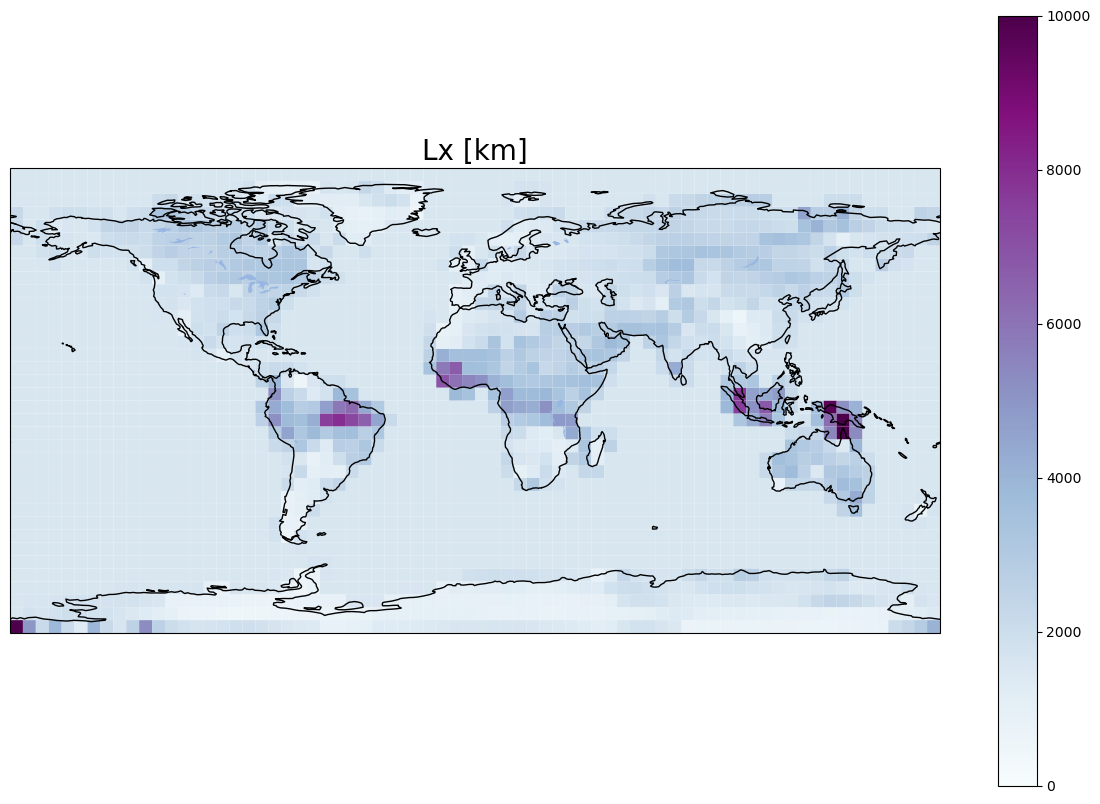

In [21]:
# iplt.contourf(Lxs, 
#               levels=L_levels, 
#               cmap=L_colormap, 
#               extend='max')
iplt.pcolor(Lxs, 
            vmin=L_levels[0],
            vmax=L_levels[-1],
            cmap=L_colormap)
plt.gca().coastlines()
plt.gca().add_feature(cfeature.LAKES)
plt.gca().set_title('Lx [km]', fontsize = 20)
plt.colorbar()

(array([1.749e+03, 5.960e+02, 1.820e+02, 3.400e+01, 1.600e+01, 6.000e+00,
        5.000e+00, 0.000e+00, 1.000e+00, 3.000e+00]),
 array([  503.13146973,  1617.30566406,  2731.47998047,  3845.65429688,
         4959.82861328,  6074.00292969,  7188.17675781,  8302.3515625 ,
         9416.52539062, 10530.70019531, 11644.87402344]),
 <BarContainer object of 10 artists>)

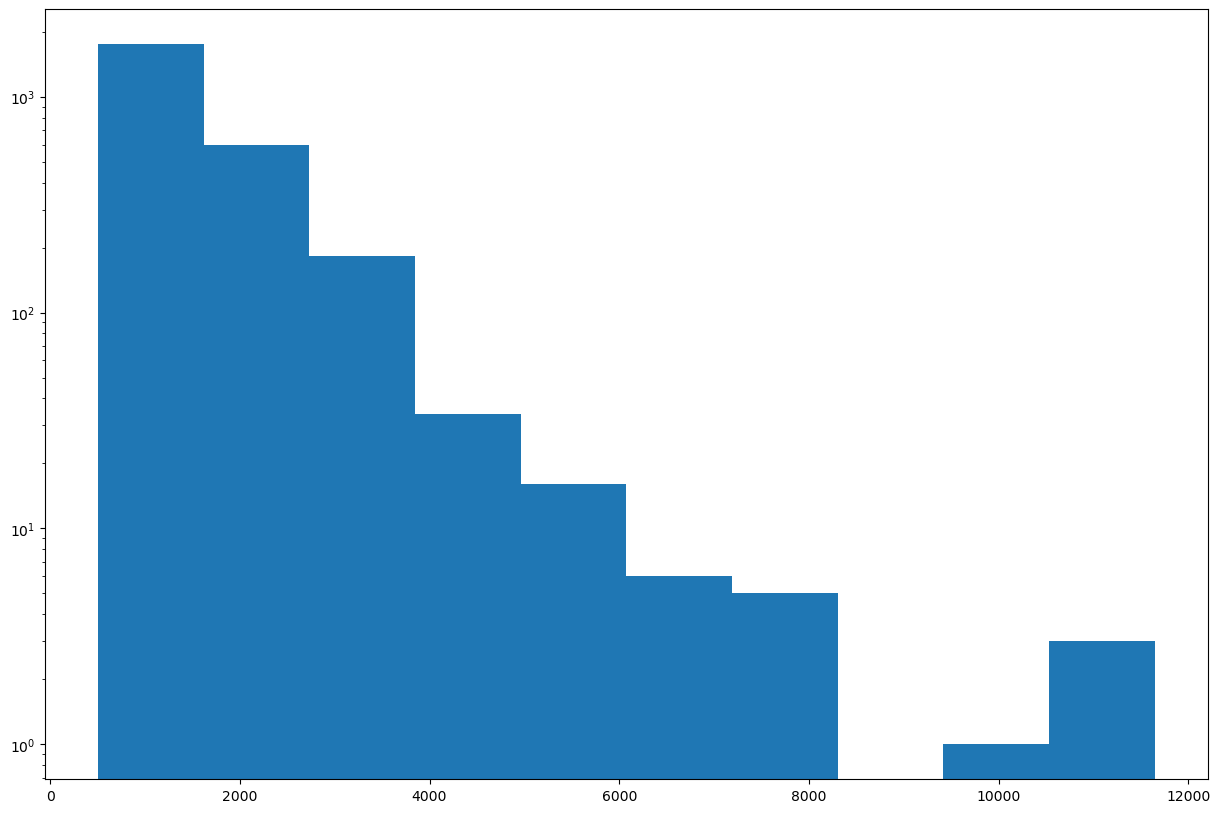

In [22]:
plt.hist(Lxs.data.compressed(), log=True)
# plt.hist(Lxs.data.compressed())

/opt/jaspy/lib/python3.11/site-packages/iris/coords.py:1979: IrisGuessBoundsWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/opt/jaspy/lib/python3.11/site-packages/iris/coords.py:1979: IrisGuessBoundsWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  warnings.warn(


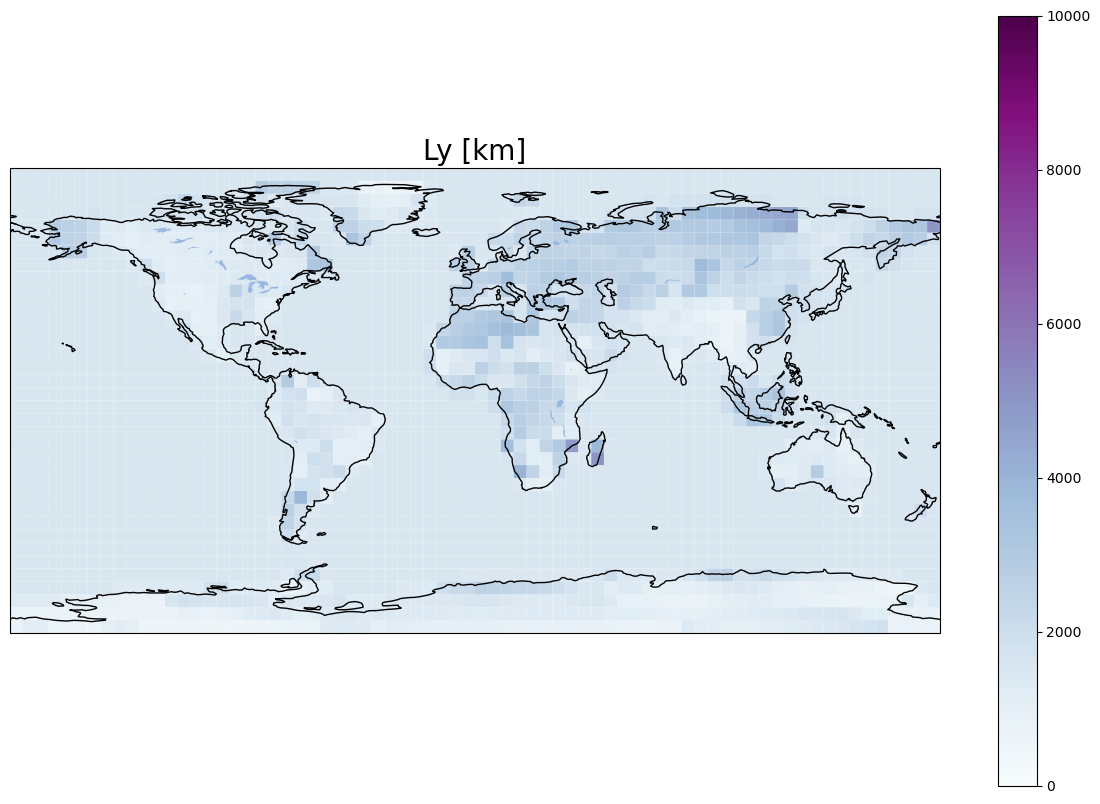

In [23]:
# iplt.contourf(Lys,
#               levels=L_levels, 
#               cmap=L_colormap, 
#               extend='max')
iplt.pcolor(Lys,
            vmin=L_levels[0], 
            vmax=L_levels[-1],
            cmap=L_colormap)
plt.gca().coastlines()
plt.gca().add_feature(cfeature.LAKES)
plt.gca().set_title('Ly [km]', fontsize = 20)
plt.colorbar()

(array([  93.,  297., 1839.,  137.,  120.,   66.,   21.,   10.,    6.,
           3.]),
 array([ 469.97622681,  930.71734619, 1391.45837402, 1852.19946289,
        2312.94067383, 2773.68164062, 3234.42285156, 3695.16381836,
        4155.90478516, 4616.64599609, 5077.38720703]),
 <BarContainer object of 10 artists>)

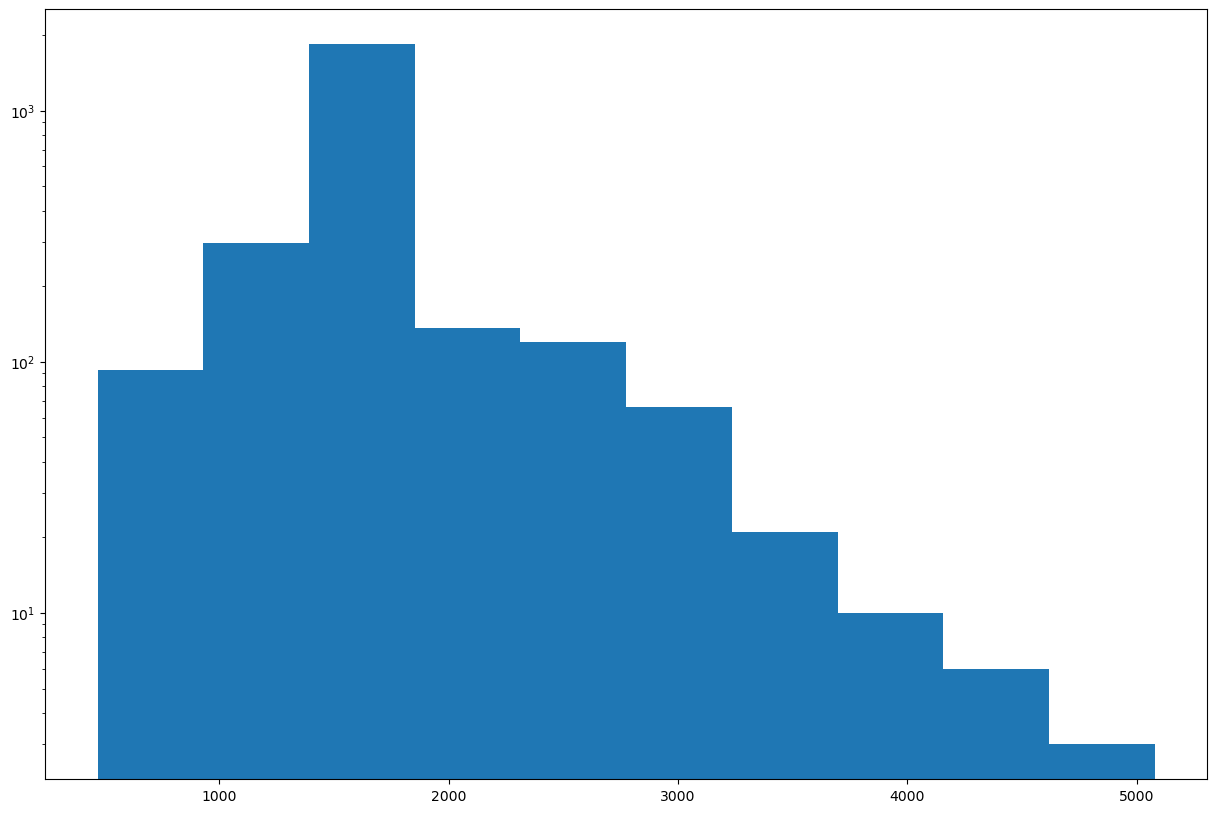

In [24]:
plt.hist(Lys.data.compressed(), log=True)

/opt/jaspy/lib/python3.11/site-packages/iris/coords.py:1979: IrisGuessBoundsWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/opt/jaspy/lib/python3.11/site-packages/iris/coords.py:1979: IrisGuessBoundsWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  warnings.warn(


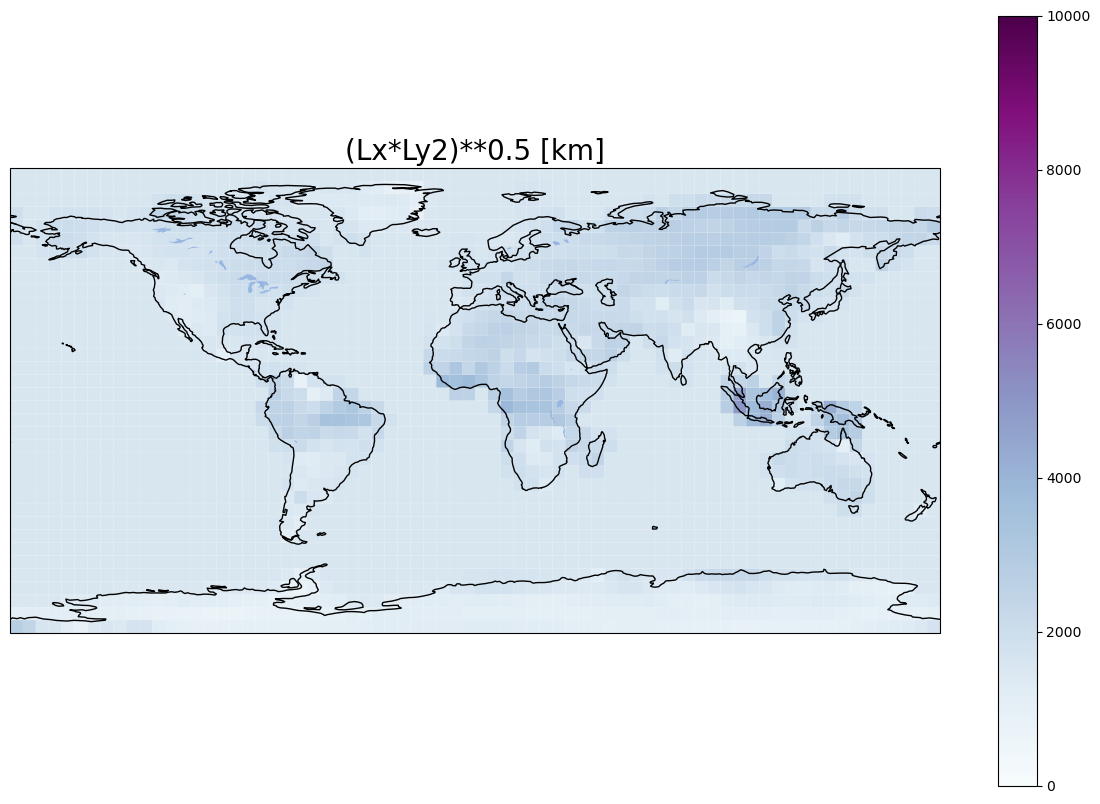

In [25]:
LxLymag = iam.exponentiate(iam.multiply(Lxs, Lys), 0.5)
# iplt.contourf(LxLymag, 
#               levels=L_levels, 
#               cmap=L_colormap, 
#               extend='max')
iplt.pcolor(LxLymag, 
            vmin=L_levels[0],
            vmax=L_levels[-1],
            cmap=L_colormap)
plt.gca().coastlines()
plt.gca().add_feature(cfeature.LAKES)
plt.gca().set_title('(Lx*Ly2)**0.5 [km]', fontsize = 20)
plt.colorbar()

/opt/jaspy/lib/python3.11/site-packages/iris/coords.py:1979: IrisGuessBoundsWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/opt/jaspy/lib/python3.11/site-packages/iris/coords.py:1979: IrisGuessBoundsWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  warnings.warn(


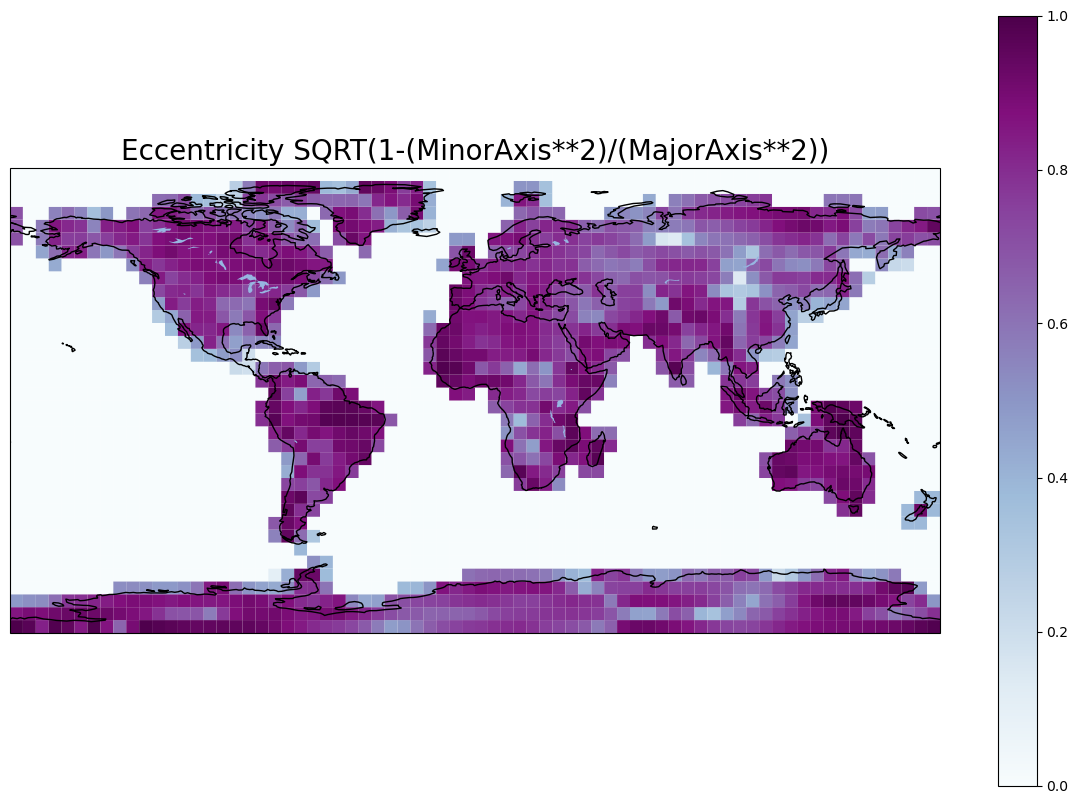

In [26]:
# iplt.contourf(eccentricity, 
#               levels=eccentricity_levels, 
#               cmap=eccentricity_colormap)
iplt.pcolor(eccentricity, 
            vmin=eccentricity_levels[0],
            vmax=eccentricity_levels[-1],
            cmap=eccentricity_colormap)
plt.gca().coastlines()
plt.gca().add_feature(cfeature.LAKES)
plt.gca().set_title('Eccentricity SQRT(1-(MinorAxis**2)/(MajorAxis**2))', fontsize=20)
plt.colorbar()

/opt/jaspy/lib/python3.11/site-packages/iris/coords.py:1979: IrisGuessBoundsWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/opt/jaspy/lib/python3.11/site-packages/iris/coords.py:1979: IrisGuessBoundsWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  warnings.warn(


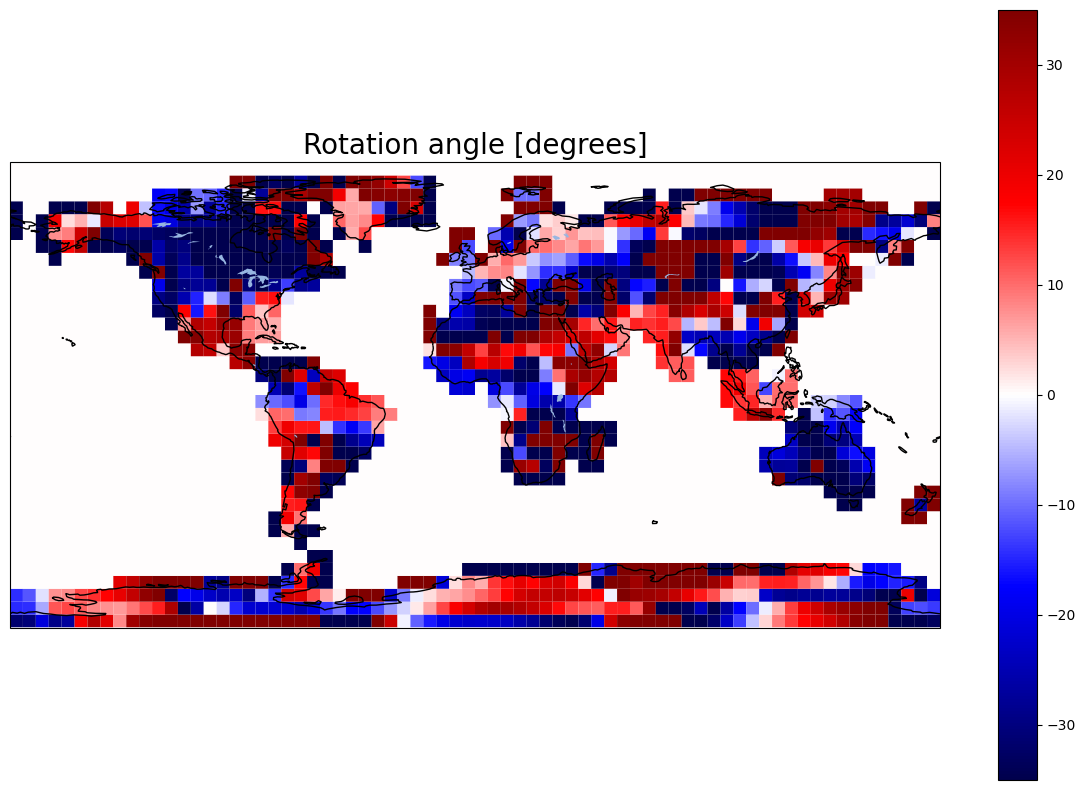

In [27]:
# iplt.contourf(thetas_deg,
#               levels=theta_levels, 
#               cmap=theta_colormap, 
#               extend='both')
iplt.pcolor(thetas_deg,
            vmin=theta_levels[0], vmax=theta_levels[-1], 
            cmap=theta_colormap)
plt.gca().coastlines()
plt.gca().add_feature(cfeature.LAKES)
plt.gca().set_title('Rotation angle [degrees]', fontsize = 20)
plt.colorbar()

/opt/jaspy/lib/python3.11/site-packages/iris/coords.py:1979: IrisGuessBoundsWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/opt/jaspy/lib/python3.11/site-packages/iris/coords.py:1979: IrisGuessBoundsWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  warnings.warn(


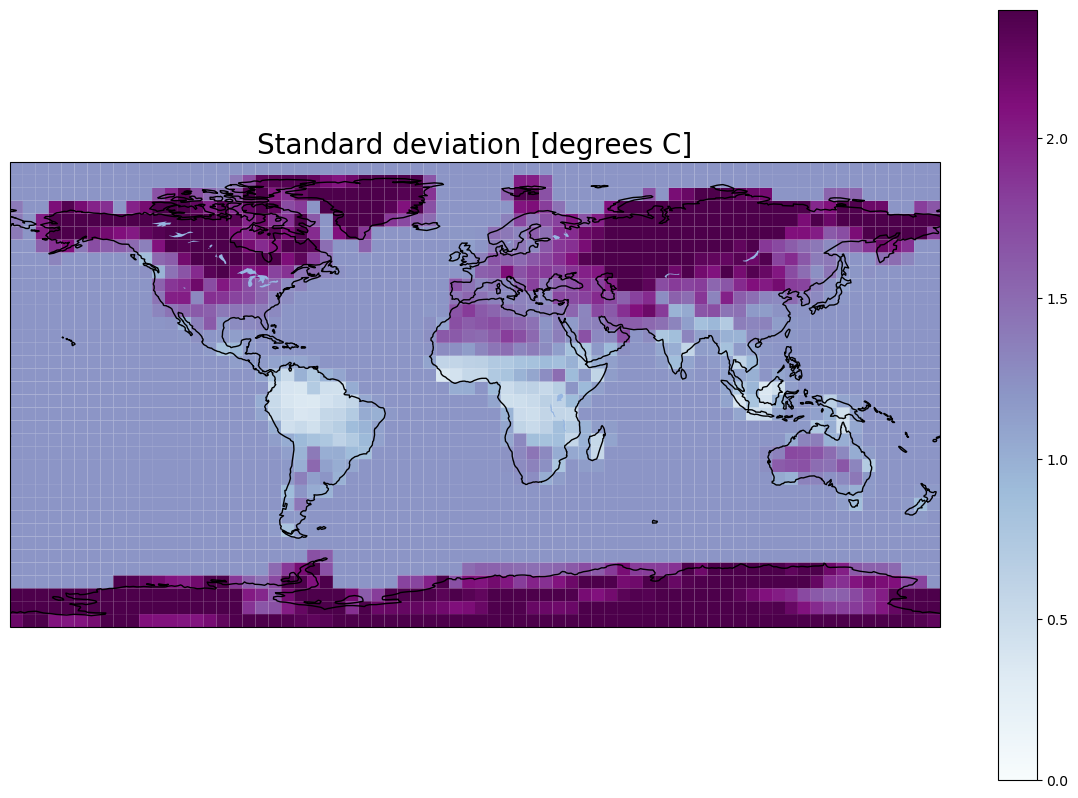

In [28]:
# iplt.contourf(sdevs, 
#               levels=sdev_levels, 
#               cmap=sdev_colormap, 
#               extend='max')
iplt.pcolor(sdevs, 
            vmin=sdev_levels[0], 
            vmax= sdev_levels[-1], 
            cmap=sdev_colormap)
plt.gca().coastlines()
plt.gca().add_feature(cfeature.LAKES)
plt.gca().set_title('Standard deviation [degrees C]', fontsize = 20)
plt.colorbar()

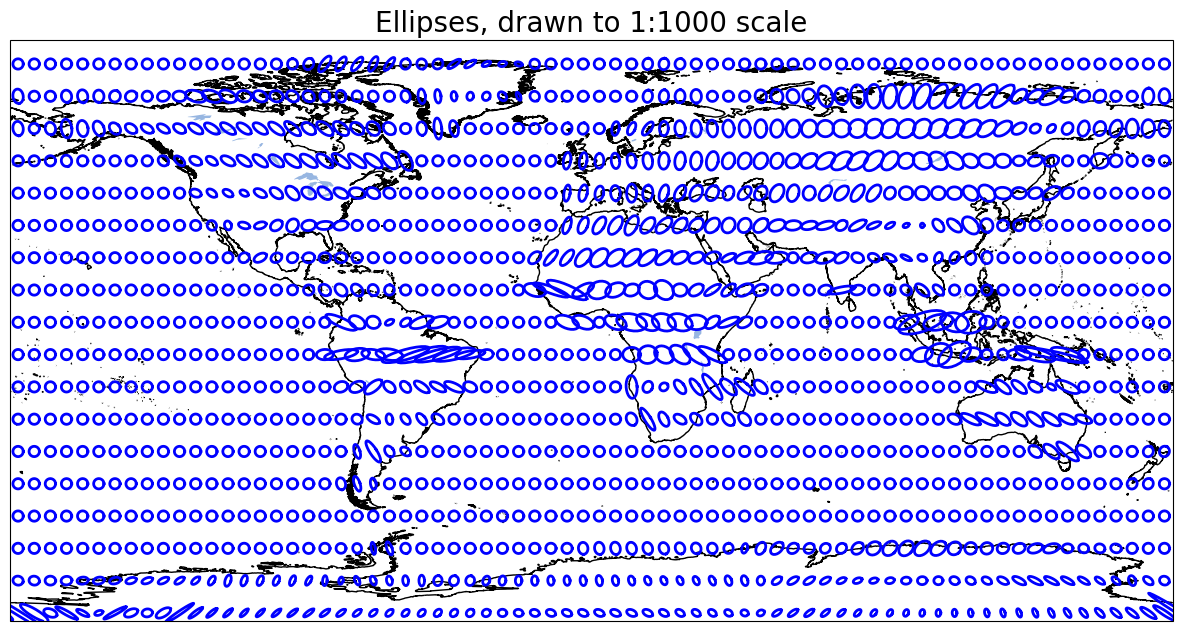

In [29]:
fig = plt.figure()
scaling = 1000
extent2 = extent
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
zipper = zip(Lxs.slices(['latitude']), Lys.slices(['latitude']), thetas.slices(['latitude']))
for zonal_count, (Lx_x, Ly_x, theta_x) in enumerate(zipper):
    zipper = zip(Lx_x.slices([]), Ly_x.slices([]), theta_x.slices([]))
    for single_cube_count, (Lx, Ly, theta) in enumerate(zipper):
        if (single_cube_count % 2) != 0:
            continue
        if np.ma.is_masked(Lx.data):
            continue    
        x0 = Lx.coord('longitude').points
        y0 = Lx.coord('latitude').points
        Lx = Lx.data
        Ly = Ly.data
        angle = theta.data
        params = (x0, y0, Lx/scaling, Ly/scaling, angle)
        xys = EllipseModel().predict_xy(np.linspace(0, 2 * np.pi, 25), params=params)
        ax.plot(xys[:,0],  xys[:,1], linewidth = 2, color = 'blue', transform=ccrs.PlateCarree())
ax.set_title('Ellipses, drawn to 1:'+str(scaling)+' scale', fontsize=20)
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.LAKES)